# Project 2: Sequence Alignment and Phylogeny


   <div class="alert alert-block alert-danger">
    <center>Due: <b>Wednesday, 29 September, 8:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    For this assignment, you are encouraged to work with one other person. Your team must satisfy these constraints:
    
   1. You **did not work together on Project 1**.
   2. You and your partner have a **total number of siblings that is divisible by two** (e.g., if you have one sibling, you need to find a partner with 1, 3, 5, or 7 siblings. If anyone has more than 7 siblings, they can partner with anyone!)
    
We expect most students will have the best learning experience on this assignment by working with a partner, but if you prefer to work alone it is permissible to do this assignment on your own.
    
You are encouraged to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from any other students in the class (other than your collaboration with your partner) or from previous offerings of this course, and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. 

You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.
    </div>

##### **Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>list each member of your team here, including both your name and UVA computing id</em></b>
    
    Amelia Norman (aln4t) and Wamia Said (ws5vhd)
</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
    
    Understanding the Smith-Waterman traceback: https://health.uconn.edu/bioinformatics/wp-content/uploads/sites/162/2017/11/Alignment_2015.pdf
    
    Neighbor-joining example
    http://evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf
</div>

 <div class="alert alert-block alert-warning">
    
<b>Submission</b>: Please submit the code you wrote to generate your answers for all parts using this form: https://forms.gle/gv144kv3KRo67uUX7. Your answers should be in the Jupyter Notebook, along with your code. Before submission, you should make a copy of your notebook file with the name uvaid1\_uvaid2.ipynb (where uvaidn is each teammates UVA id) so the submitted file identifies you. You and your partner should submit a single file once together. Submission is due 8:59 pm on Wednesday, 29 September.

## Getting Started

Install basic required packages, should be run only once. You may need to restart the jupyter python kernel (under the Kernel menu) after this. (You can execute this directly in the notebook but running the command below.)

In [201]:
%pip install -r requirements.txt

  Cloning https://github.com/iamgroot42/blosum.git to c:\users\wamia\appdata\local\temp\pip-req-build-symvk85y
  Resolved https://github.com/iamgroot42/blosum.git to commit 433ed2f1b55fa010ad1b4b2a84158c1f38ddeaf6
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/iamgroot42/blosum.git 'C:\Users\Wamia\AppData\Local\Temp\pip-req-build-symvk85y'
You should consider upgrading via the 'C:\Users\Wamia\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [202]:
import numpy as np
import blosum as bl
import networkx as nx
import matplotlib.pyplot as plt
import utils
from itertools import chain

## Part 1: Global Sequence Alignment

Below we provide the sequence alignment code from [Class 6](https://computingbiology.github.io/class6/). You are welcome to use and modify this code however you want in your solution, but should answer the questions below based on this provided code.

In [203]:
def simpleMatch(a, b):
    return 1 if a == b else -1

def distanceMatch(a, b):
    return 0 if a == b else -1

def linearGap(n):
    return -1 * n

def alignmentScore(s1, s2, gapPenalty, match):
    if not s1 or not s2:
        return gapPenalty(len(s1)) + gapPenalty(len(s2))
    else:
        return max(gapPenalty(1) + alignmentScore(s1, s2[1:], gapPenalty, match), 
                   gapPenalty(1) + alignmentScore(s1[1:], s2, gapPenalty, match),
                   match(s1[0], s2[0]) + alignmentScore(s1[1:], s2[1:], gapPenalty, match)) 

In [204]:
def alignmentScoreDP(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(gapPenalty(1) + m[i, j - 1],  
                          gapPenalty(1) + m[i - 1, j],    
                          match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1]) 
    return m
    
def readAlignment(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = "" 
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            score += match(s1[i], s2[j])
            s1a = s1[i] + s1a
            if s1[i] == s2[j]:
                s2a = s2[j] + s2a
            else:
                s2a = s2[j].lower() + s2a
        elif i > 0 and m[i, j] == m[i - 1, j] + gapPenalty(1):
            i = i - 1
            score += gapPenalty(1)
            s1a = s1[i] + s1a
            s2a = '-' + s2a
        elif j > 0 and m[i, j] == m[i, j - 1] + gapPenalty(1):
            j = j - 1
            score += gapPenalty(1)
            s1a = '-' + s1a
            s2a = s2[j] + s2a
        else:
            assert False
    return (s1a, s2a, score)

def showAlignment(s1, s2, gapPenalty, match):
    m = alignmentScoreDP(s1, s2, gapPenalty, match)
    r = readAlignment(s1, s2, m, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [205]:
# Example
r = showAlignment("GATT", "GCAT", linearGap, simpleMatch)

G-ATT
GCA-T
1


Here's the version that supports affine gap penalties (from Class 6):

In [206]:
def alignmentScoreDPG(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):         
            m[i, j] = max(chain((gapPenalty(g) + m[i, j - g] for g in range(1, j + 1)),
                                (gapPenalty(g) + m[i - g, j] for g in range(1, i + 1)),   
                                [(match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])]))
    return m
    
def readAlignmentG(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = ""
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            s1a = s1[i] + s1a
            s2a = (s2[j] if s1[i] == s2[j] else s2[j].lower()) + s2a
            score += match(s1[i], s2[j])
        else:
            foundit = False
            for g in range(1, i + 1):
                if m[i, j] == m[i - g, j] + gapPenalty(g):
                    s1a = s1[i - g:i] + s1a
                    s2a = ('-' * g) + s2a
                    i = i - g
                    score += gapPenalty(g)
                    foundit = True
                    break
            if not foundit:
                for g in range(1, j + 1):
                    if m[i, j] == m[i, j - g] + gapPenalty(g):
                        s1a = ('-' * g) + s1a
                        s2a = s2[j - g:j] + s2a
                        j = j - g
                        score += gapPenalty(g)
                        foundit = True
                        break
            assert foundit
    return (s1a, s2a, score)

def showAlignmentG(s1, s2, gapPenalty, match):
    m = alignmentScoreDPG(s1, s2, gapPenalty, match)
    r = readAlignmentG(s1, s2, m, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [207]:
def affineGap(n, gp = -1, gn = -0.2):
    return gp + (n - 1) * gn

In [208]:
# Example
s1 = "AAAGAATTCA"
s2 = "AAATCA"
r = showAlignmentG(s1, s2, affineGap, simpleMatch)

AAAGAATTCA
AAA----TCA
4.4


<div class="alert alert-success">

**Problem 1 (a).** Run the given algorithm to find a global sequence alignment for the OCA2 genes (a key gene for the production of melanin) for humans and mice with the following gap penalties (still using simpleMatch as the match score function):

  a. `linearGap` penalty
    
  b. `affineGap` penalty, with $gp=-0.2$

  c. `affineGap` penalty, with $gp=-0.1$
    
</div>


In [209]:
human_oca2, mouse_oca2 = utils.load_oca2_sequences()

In [210]:
# a: global sequence alignment for OCA2 gene -- linearGap penalty
oca2_lg = showAlignment(human_oca2, mouse_oca2, linearGap, simpleMatch)

-GTTCT--TACTTCGAAG-GCTGTGCTCCG----CTCACCATCCAGAGCGGAGGTGCGGACC-T-TA-AACTCA-CTCC--TGGA----GA-A--AGATCTGCAAGTGC-GCAGAGAGAAGACTGGCAGTGGAGCATGCATCTGGAGGGCAGAGACGGC-A-GGCGGTACCCCGGCGCGCCGGCG-GTGGAGCTCCTGCAGACGTCCGTGCC-CAGCGGACTCGCT-GAACTTGTGGC--CGGCA-AGC
CccTCTGGggCTgC-AAGTGC-cTGCTgaGAAATCTtA-CA-CC--AG-GGttGTGC--tCCATCcACgACTCAGagCCTTTGGATCTGGACACTAGA-CTtC-AcTGCTG--GAGAG-AGA-T--CAG-cGAG--T-CATC---A-GaCAGA-tCaGCAACGG-GG-A--CatGCGC-CtaGaGAacaaAG-aCaT-CAG--G-CtG-GCCTCAGCcG--T-GCTGGAAgTaG-aGCTACacCAGA-C
25


In [211]:
# create new function
def newAffine(n):
    return affineGap(n, gp=-0.2)

In [212]:
# ASK FOR CLARITY HERE -- IS IT GP OR GN? ARE WE SUPPOSED TO USE THE INITIAL FUNCTION PROVIDED??

oca2_ag2 = showAlignmentG(human_oca2, mouse_oca2, newAffine, simpleMatch)

---------G-T-----T-C-T--T---A---CTT-CGA--A-GG-CTGTGCTCC--GCTCAC--CATCCAGAG-C---GGAGGTGC-GGAC-CTTAA-AC-TCACT-CCTGGAGA-AAGATC-TGC-AAGTGC--GCAGA-GAGA--AG--ACTGGCAGTGGAGCAT--GCATCT-G-G-AGGGC-AGAGAC--GGCAGGC-GGTACCC-C-GGCGCG-CCGGCGGTGG-AGCTCCTGCAGACGTCCGTGCCCAGCGGACTCGCTGAACTTGTGGCCGGCAAGC
CCCTCTGGGGCTGCAAGTGCCTGCTGAGAAATCTTAC-ACCAGGGT-TGTGCTCCAT-C-CACGAC-T-CAGAGCCTTTGGA--T-CTGGACACT--AGACTTCACTG-CTGGAGAG-AGATCA-GCG-AGT-CAT-CAGAC-AGATCAGCAAC-G---G-GGA-CATGCGC--CTAGAGAA---CAA-AGACAT--CAGGCTGG---CCTCA-GC-CGT---GC--TGGAAG----T--AGA-G--C-T----A-C--AC---C---A---------G---A-C
112.1999999999998


In [213]:
def thirdAffine(n):
    return affineGap(n, gp=-0.1)

In [214]:
# c: global sequence alignment for OCA2 gene -- affineGap penalty, gp=-0.1

oca2_ag2 = showAlignmentG(human_oca2, mouse_oca2, thirdAffine, simpleMatch)

------G----T-----T--CT--T-A-----CTT-CGA--A-GG-CTGTGCTCC--GCTCAC--CATCCAGAG-C---GGAGGTGC-GGAC-CTTA-AAC-TCACT-CCTGGAGA-AAGATC-TGC-AAGTGC--GCAGA-GAGA--AG--ACTGGCAGTGGAGCAT--GCATCT-G-G-AGGGC-AGAGAC--GGCAGGC-GGTACC-C-CGGCGCG-CCGGCGGTGG-AGCTCCTGCAGACGTCCGTGCCCAGCGGACTCGCTGAACTTGTGGCCGGCAAGC
CCCTCTGGGGCTGCAAGTGCCTGCTGAGAAATCTTAC-ACCAGGGT-TGTGCTCCAT-C-CACGAC-T-CAGAGCCTTTGGA--T-CTGGACAC-TAG-ACTTCACTG-CTGGAGAG-AGATCA-GCG-AGT-CAT-CAGAC-AGATCAGCAAC--G--G-GGA-CATGCGC--CTAGAGAA---CAA-AGACAT--CAGGCTGG--CCTCA--GC-CGT---GC--TGGAAG----T--AGA-G--C-T----A-C--A--C-C---A----------G--A-C
126.10000000000025


<div class="alert alert-success">

**Problem 1 (b).** Use the given function to convert these sequences to their amino-acid sequences, and then re-run alignment for all sequences with the default parameters for `affineGap`.
</div>


In [215]:
# Convert sequence of nucleotides to amino acids using codon table lookup
# Example
utils.convert_to_amino("AAATGCGGCGTA")

'KCGV'

In [216]:
# Your code here
human_oca2_amino = utils.convert_to_amino(human_oca2)
mouse_oca2_amino = utils.convert_to_amino(mouse_oca2)

amino_alignment = showAlignmentG(human_oca2_amino, mouse_oca2_amino, affineGap, simpleMatch)

VLTSKAVLRS-----------PSRAEVRTLNSL----L-----E------KDLQVR----RE----------KTGSGACIWRAETAGGTPARRRWSSCRRPCPADSLNLWPAS
--pSgA--aSAC_EILHQGCAPS-----TtqSLWIWTLDFTAGERSASHQtD-QqRGHAPREQRHQAGLSRA--GS-----RA-----TP--------------D--------
-13.799999999999999


## Part 2: Alignment with Amino-Acids


The PAM<em>n</em> matrix (to be covered in [Class 6](https://computingbiology.github.io/class6/)) represents the likelihood of the occurrence of each tranformation during a time period where there are _n_ total mutation events per 100 amino acids.

<div class="alert alert-success">

**Problem 2 (a)** What would a negative value of an entry in a PAM 1 matrix $M$ indicate? Explain in terms of evolution and functionality of the proteins. Note that $M_{ij} = log(\frac{q_{ij}}{p_ip_j})$ where $q_{ij}$ indicates the frequency of amino acids $i$ and $j$ observed to align in related sequences, and $p_i$ and $p_j$ represent the frequencies of occurrence of $i$ and $j$.
</div>

A negative entry in a PAM_n matrix would indicate that the sequences *i* and *j* are unrelated, meaning that they are unlikely to be substituted for one another. In terms of functionality, this would mean that they are dissimilar because proteins that are more functionally similar are more likely to be substituted for one another (especially at the nucleotide level, which initially encodes the proteins, e.g. adenines being interchanged for one anothr or thymines doing the same). In terms of evolution, this would mean that the two proteins would have (INSERT EVOLUTION)

<div class="alert alert-success">
    
**Problem 2 (b).** The BLOSUM<em>x</em> matices are created by clustering sequences with more than <em>x</em>% similarity into one single sequence and comparing sequences with more than <em>x</em>% divergence. Therefore, BLOSUM matrices are based on local alignments. Which of BLOSUM 50 and 60 contain more evoluationary divergence? 
    
</div>

BLOSUM 50

<div class="alert alert-success">

**Problem 2 (c).** Use the BLOSUM62 matrix as your scoring function to perform global alignment on the amino-acid sequences using `linearGap` (default parameters).
</div>

In [217]:
blosum_matrix = bl.BLOSUM(62)

In [218]:
# Edit global alignment function to make up for two amino acid sequences
def showAlignmentBLO(s1, s2, gapPenalty, match):
    r = readAlignmentG(s1, s2, blosum_matrix, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return r

In [219]:
blosum_align = showAlignmentBLO(human_oca2_amino, mouse_oca2_amino, linearGap, simpleMatch)   # Ask in OH

VLTSKAVLRSPSRAEVRTLNSLLEKDLQVRREKTGSGACIWRAETAGGTPARRRWSSCRRPCPADSLNLWPAS
----psgaaSac_eilhqgcapsttqslwiwtldftagersashqtdqqrghapreqrhqaglsragsratpd
-71


<div class="alert alert-success">

**Problem 2 (d).** How do your results for Problem 2c differ from the earlier ones of Problem 1a (with `linearGap`)? Which one would you say is more biologically plausible?
</div>

Our results for 2C were more negative than our results from 1A, implying that there are more differences in the encoding of the human OCA2 and mouse OCA2 genes than demonstrated in 1A. However, I would believe that 1A is more biologically plausible because the DNA sequences here produce the same hormone, and about <a href="https://www.nih.gov/news-events/news-releases/new-comprehensive-view-mouse-genome-finds-many-similarities-striking-differences-human-genome#:~:text=However%2C%20they%20also%20uncovered%20many,1.5%20percent%20of%20these%20genomes.">70% of protein-encoding DNA is shared between mice and humans. </a>

<div class="alert alert-success">

**Problem 2 (e).** We discussed in class that the PAM matrices follow the Markov property and a mismatch at any site depends only on the amino acid at that site and the transition probability. Is this a suitable representation of evolution? Think about if replacements are equaly likely to occur over entire sequences. It may help to consider the difference between PAM and BLOSUM matrices.
</div>

PAM is a suitable representation of evolution because mutations are not dependent on the mutations that occurred in the past. The PAM120 and BLOSUM62 matrices are fairly similar to each other so both models seem to produce similar results.

## Part 3: Local Sequence Alignment


<div class="alert alert-success">
    
<b>Problem 3 (a).</b> Implement local alignment (for both the normal and affine-gap penalties) using the Smith-Waterman algorithm. Feel free to re-use and modify the given Needleman–Wunsch algorithm. 
</div>

In [220]:
# create dynamic programming algorithm
def smithWaterman(s1, s2, gapPenalty, match):
    # 1: Determine the substitution matrix and the gap penalty scheme.
    #    using normal and affine; passing in function as parameter
    
    # 2&3: Construct and fill in scoring matrix
    # m is the scoring matrix
    # we edited alignmentScoreDPG() for this to avoid negative values since negative values are not included in 
    # Smith-Waterman algorithm
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        temp = gapPenalty(i)
        if temp > 0:
            m[i, 0] = temp
        else:
            m[i, 0] = 0
    for j in range(1, len(s2) + 1):
        if temp > 0:
            m[0, j] = temp
        else:
            m[0, j] = 0
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):  
            temp = max(chain((gapPenalty(g) + m[i, j - g] for g in range(1, j + 1)),
                                (gapPenalty(g) + m[i - g, j] for g in range(1, i + 1)),   
                                [(match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])]))
            if temp > 0:
                m[i, j] = temp
            else:
                m[i, j] = 0
        
    # 4: Traceback
    
    # attempt 1 traceback
    # can inherit diagonal (left), left, or up -- if left or up, read gap into sequence
    sequence_1 = ''
    sequence_2 = ''
    max_val = np.unravel_index(np.argmax(m, axis=None), m.shape)   # returns (row, col) tuple
    curr = max_val
    # print(max_val)
    score = 0
    
    # support for affineGap
    penalty_length = 0
    
    
    while m[curr[0], curr[1]] != 0:   # end condition; reaches point = 0
        # find max of 3 possible nodes and select that one that is max (figure out wikipedia example later)
        # never going to have index errors; values on the first row/col are 0
        up = m[curr[0]-1, curr[1]]
        left = m[curr[0], curr[1]-1]
        diagonal = m[curr[0]-1, curr[1]-1]
        
        options = [diagonal, up, left]
        
        if max(options) == diagonal:  
            # append corrects vals to both local alignments (remember to fix order later)
            sequence_1 += s1[curr[0]-1]
            sequence_2 += s2[curr[1]-1]
            curr = tuple((curr[0]-1, curr[1]-1))
            score += 1   # check if this is the correct approach here
            if penalty_length > 0:
                score += gapPenalty(penalty_length)
            penalty_length = 0   # reset gap length
        
        elif max(options) == up:   
            # append '-' to s1 and actual nucleotide to s2
            if (curr[0]-1) != 1:
                sequence_2 += '-'
                sequence_1 += s1[curr[0]-1] # this corresponds to columns?? so there is no reason why this should be out of bounds
                penalty_length += 1
            curr = tuple((curr[0]-1, curr[1]))
            
        else:
            # append '-' to s2 and actual nucleotide to s2
            sequence_2 += s2[curr[1]-1]
            sequence_1 += '-'
            curr = tuple((curr[0], curr[1]-1))
            penalty_length += 1
        
    # add remaining penalty to score
    if penalty_length > 0:
        score += gapPenalty(penalty_length)
    
    # reverse strings into correct order
    sequence_1 = sequence_1[::-1]
    sequence_2 = sequence_2[::-1]
    
    return (score, sequence_1, sequence_2)
    
    

In [221]:
def showAlignmentLocal(s1, s2, gapPenalty, match):
    # Although it is often useful to return all high scoring local alignments for an input pair, 
    # it is sufficient if your algorithm just returns the single highest-scoring local alignment 
    # (as shown in the examples below).
    
    # Your code here (implement)
    res = smithWaterman(s1, s2, gapPenalty, match)
#     print(res[1])
#     print(res[2])
#     print(res[0])
    return res

We've included some assert statements that can help you check the correctness of your algorithm. As with any algorithm, correctness on these test inputs does not guarantee algorithmic correcntess, but can be useful to debug.

In [222]:
# Example expected output
# Taken from https://en.wikipedia.org/wiki/Smith–Waterman_algorithm)
r = showAlignmentLocal("GGTTGACTA", "TGTTACGG", linearGap, simpleMatch)

"""
output: 
GTTGAC
GTT-AC
4
"""

'\noutput: \nGTTGAC\nGTT-AC\n4\n'

In [223]:
# First assert
r = showAlignmentLocal("GGTTGACTA", "TGTTACGG", linearGap, simpleMatch)
# print(r)
assert (r[0] == 4 and "GTTGAC" in r[1] and "GTT-AC" in r[2])
"""
GTTGAC
GTT-AC
4
"""

# Second assert
r = showAlignmentLocal("GGACTTAAATAGA", "TGTTGGTGATCCACGTGG", linearGap, simpleMatch)
assert (r[0] == 2 and "GG" == r[1] and "GG" == r[2])
"""
GG
GG
2
"""

# Third assert
r = showAlignmentLocal("TTGA", "GGCC", linearGap, simpleMatch)
assert (r[0] == 1 and "G" == r[1] and "G" == r[2])
"""
G
G
1
"""

# Fourth assert
r = showAlignmentLocal("TACGGGCCCGCTAC", "TAGCCCTATCGGTCA", linearGap, simpleMatch)
assert (r[0] == 4 and "TA-CGG" in r[1] and "TATCGG" in r[2])
"""
TA-CGG
TATCGG
4
"""

'\nTA-CGG\nTATCGG\n4\n'

<div class="alert alert-success">
    
<b>Problem 3 (b).</b> Align the provided hemoglobin genes for:
    <ol>
        <li>`polar bears` & `black bears`,</li>
        <li>`humans` & `chimps`,</li>
        <li>`polar bears` & `humans`, and</li>
        <li>`black bears` & `chimps`.</li>
    </ol>

Use `linearGap`.
    
Take note of the scores you get. What do you notice?
</div>

In [224]:
polar_bear, black_bear, human, chimp = utils.get_hemoglobin_sequences()

In [225]:
# 1: polar bears and black bears
pb_bb = showAlignmentLocal(polar_bear, black_bear, linearGap, simpleMatch)
# returns 330 

In [226]:
# 2: humans and chimps
h_c = showAlignmentLocal(human, chimp, linearGap, simpleMatch)
# returns 797

In [227]:
# 3: polar bears and humans
pb_h = showAlignmentLocal(polar_bear, human, linearGap, simpleMatch)
# returns 537

In [228]:
# 4: black bears and chimps
bb_c = showAlignmentLocal(black_bear, chimp, linearGap, simpleMatch) 
# returns 262

**RESPONSE**

Of the sequence pairs we compared, humans and chimps were the most similar with a score of 797. This means that the sequences are mostly similar since their sequence lengths are 843 and 836, respectively. This makes sense because, compared to the other pairs, humans and chimps have more recent shared ancestry. 

Polar bears and black bears, despite being both labelled "bear" have more difference in their hemoglobin sequence than humans and chimps. Their score was 330. This means that the species diverged from one another further in evolutionary history than humans and chimps. 

The least similar pair analyzed was black bears and chimps, who had a score of 262. These species must have diverged the most early in evolutionary history of the pairs we have analyzed. However, this is interesting because polar bears and humans have a score of 537, which raises interesting questions about the pattern of evolution and relationship between bears, chimps, and humans. Could polar bears have been related to chimps for a longer period of time before the evolution of humans? Were polar bears and humans closer to one another and had some shared characteristics? Or is this just coincidence? 

We further analyzed this question in the cells below, where we found the scores for black bears and humans and polar bears and chimps. The first sequence analysis returned expected results - black bears and humans were less similar than black bears and chimps. Humans are descended from other primates (e.g. chimps) and thereby have evolved further from chimps, reducing the similarities between black bears and humans. The second sequence analysis found that chimps and polar bears were *more* similar than humans and polar bears. This makes sense for the same reasons explained previously; primates and bears likely diverged more recently in the evolutionary story than black bears and primates. It is odd, however, that black bears and polar bears share less in common than polar bears with either humans or chimps.

In [229]:
# for reference
bb_h = showAlignmentLocal(black_bear, human, linearGap, simpleMatch)

In [230]:
pb_c = showAlignmentLocal(polar_bear, chimp, linearGap, simpleMatch)  

<div class="alert alert-success">

<b>Problem 3 (c).</b> Use <a href="https://blast.ncbi.nlm.nih.gov/">BLAST</a> for the above pairs of sequences. Carefully inspect the returned results to see if they are similar to the alignments you obtained above.
</div>

The following table depicts the BLAST results:

| Sequence 1 | Sequence 2 | Match % | Number matches | Gap % | Score |
| ---------- | ---------- | ------- | -------------- | ----- | ----- |
| Polar bears | Black bears | 69% | 585/851 | 30% | 619 |
|Humans | Chimps | 97% | 821/844 | 1% | 1567 |
| Polar bears | Humans | 75% | 662/887 | 9% | 609 |
| Black bears | Chimps | 57% | 494/864 | 35% | 106 |


The BLAST results are fairly similar to our own results, aside from some larger differences in the scoring function (ours is just +1 for every match and -1 for every gap); theirs seems to reward longer sequences and penalize longer gaps more heavily than our model. The sequence alignments themselves were very similar; some of the longer stretches were identical to our own results!


<div class="alert alert-success">

<b>Problem 3 (d).</b> Could you run an affine-gap-loss version of your local-alignment algorithm for the given sequences? How much time did BLAST take?
Can you think of any optimizations you could make to make the affine-gap-loss version run faster- perhaps utilizing parallel processing or GPUs?
</div>

We could run an affine-gap-loss version of our local alignment algorithm. We check for the length of the exisiting gap and add the penalty to the score at either the next match or end of the sequence. 

BLAST took less than 1 second to process our sequences, but ours takes a few minutes. We could improve our process by making our code more efficient (there may be places where we could improve speed via hashing or reduce the number of loops we use. We could also utilize pruning through the process. Of course, because Smith-Waterman is a dynamic programming algorithm, it inherently requires more space and is more expensive to compute in order to get the desired solution. As a result, external improvements (using a GPU, parallel processing, or ssh-ing into a computer with better processing speed) may be the best strategies to improve the speed.

In [231]:
# running an affineGap version once as an example
# polar bears and black bears
a_pb_bb = showAlignmentLocal(polar_bear, black_bear, affineGap, simpleMatch)

## Part 4: Phylogenetic Tree Reconstruction

For this part, we'll briefly enter a fictional setup where you want to trace the evolution of Pokémon. The data is in the format of a two lists: one each for the sequences themselves, and names of the Pokémons.

<div class="alert alert-success">
    
**Problem 4 (a).** Implement an algorithm for Phylogenetic Tree Reconstrution using the neighbor joining algorithm. Color intermediate nodes different from leaf nodes. Use given names as node labels in your visualization.
    
For computing the distances matrix, use affine-based gap-loss in your alignment score computations.
    
</div>

You can either label intermediate nodes in the Phylogenetic tree such that they start with "intermediate_" and use the given functions below, or use your own nomenclature/way of handling those node, and modify the given helper functions accordingly.

We've provided a helper function to plot a given Phylogenetic tree

In [281]:
def get_dist_matrix(sequences):
    dist_mat = np.zeros( [len(sequences), (len(sequences))] )
    
    for i in range(0, len(sequences)):
        for j in range(0, len(sequences)):
            if i == j:
                dist_mat[i][j] = 0
                continue
            m = alignmentScoreDPG(sequences[i], sequences[j], affineGap, simpleMatch)
            score = readAlignmentG(sequences[i], sequences[j], m, affineGap, simpleMatch)[2]
#            score = showAlignmentLocal(sequences[i], sequences[j], affineGap, simpleMatch)[0]
            dist_mat[i][j] = 100/score
            
#             dist_mat[i][j] = showAlignmentLocal(sequences[i], sequences[j], affineGap, simpleMatch)[0]

    return dist_mat

def construct_alignment(dist, names):
    G = nx.Graph()
    
    n = len(dist)
    while n > 2:
        # step 1
        s_vals = list()
        for row in dist:
            s = sum(row)/(n-2)
            s_vals.append(s)
        
        # step 2
        m_val = float("inf")
        m_val_i = np.nan
        m_val_j = np.nan
        for i in range(0, len(s_vals)):
            for j in range(0, len(s_vals)):
                if i == j:
                    continue
                temp = dist[i][j] - s_vals[i] - s_vals[j]
                if temp < m_val:
                    m_val = temp
                    m_val_i = i
                    m_val_j = j
        
        # step 3
        if names[m_val_i] not in G: 
            G.add_node(names[m_val_i])
        if names[m_val_j] not in G: 
            G.add_node(names[m_val_j])
        # u_name = "intermediate_" + names[m_val_i] + names[m_val_j]
        u_name = "i_" + names[m_val_i] + names[m_val_j]
        if u_name not in G:
            G.add_node(u_name)
            
        s_i = dist[m_val_i][m_val_j]/2 + (s_vals[m_val_i] - s_vals[m_val_j])/2
        s_j = dist[m_val_i][m_val_j]/2 + (s_vals[m_val_j] - s_vals[m_val_i])/2
        
        # step 4
        G.add_weighted_edges_from([(u_name, names[m_val_i], s_i), (u_name, names[m_val_j], s_j)])
        
        names.append(u_name)
        names[m_val_i] = None
        names[m_val_j] = None
        names = list(filter(None, names))
        
        # step 5
        u = np.zeros([len(dist), 1])
        for x in range(0, n):
            u[x] = (dist[x][m_val_i] + dist[x][m_val_j] - dist[m_val_i][m_val_j]) / 2
    
        dist = np.append(dist, u, axis=1)
        u_transposed = np.transpose(u)
        # to account for dist[u][u]
        u_transposed = np.append(u_transposed, [[0]], axis=1)
        dist = np.append(dist, u_transposed, axis=0)
        
        dist = np.delete(dist, m_val_j, 0)
        dist = np.delete(dist, m_val_j, 1)
        dist = np.delete(dist, m_val_i, 0)
        dist = np.delete(dist, m_val_i, 1)
        
        n = len(dist)
    
    assert(len(names) == 2)
    G.add_edge(names[0], names[1], weight=dist[0][1])
    return G

In [234]:
def draw_graph_nice(G):
    """
        Helper function to plot a given Phylogenetic tree.
        Assumes intermediate node names start with 'intermediate_'
    """
    nodes = list(G.nodes)
    # Plot intermediate nodes smaller
    # sizes = [10 if "intermediate_" in x else 2000 for x in nodes]
    sizes = [10 if "i_" in x else 2000 for x in nodes]
    labels = {}    
    for node in nodes:
#         if not node.startswith("intermediate_"):
        if not node.startswith("i_"):
            labels[node] = node
    fig, ax = plt.subplots(figsize=(15,15))
    nx.draw_planar(G, node_size=sizes, with_labels=True, node_color = "#ADD8E6")

Here's the visualization for the given example on Wikipedia to get a sense of what the output should look like. We use `networkx` for creating and managing the graphs.

In [282]:
# Wikipedia example: https://en.wikipedia.org/wiki/Neighbor_joining
distances = np.array([
    [0, 5, 9, 9, 8],
    [5, 0, 10, 10, 9],
    [9, 10, 0, 8, 7],
    [9, 10, 8, 0, 3],
    [8, 9, 7, 3, 0]
], dtype=float)

# distances = np.array([
#     [0, 5, 4, 7, 6, 8],
#     [5, 0, 7, 10, 9, 11],
#     [4, 7, 0, 7, 6, 8],
#     [7, 10, 7, 0, 5, 9],
#     [6, 9, 6, 5, 0, 8],
#     [8, 11, 8, 9, 8, 0]
# ], dtype=float)

seq_names = ["a", "b", "c", "d", "e"]
G = construct_alignment(distances, seq_names)
print(G.edges(data=True))

[('a', 'i_ab', {'weight': 2.0}), ('b', 'i_ab', {'weight': 3.0}), ('i_ab', 'i_ci_ab', {'weight': 3.0}), ('c', 'i_ci_ab', {'weight': 4.0}), ('i_ci_ab', 'i_de', {'weight': 2.0}), ('d', 'i_de', {'weight': 2.0}), ('e', 'i_de', {'weight': 1.0})]


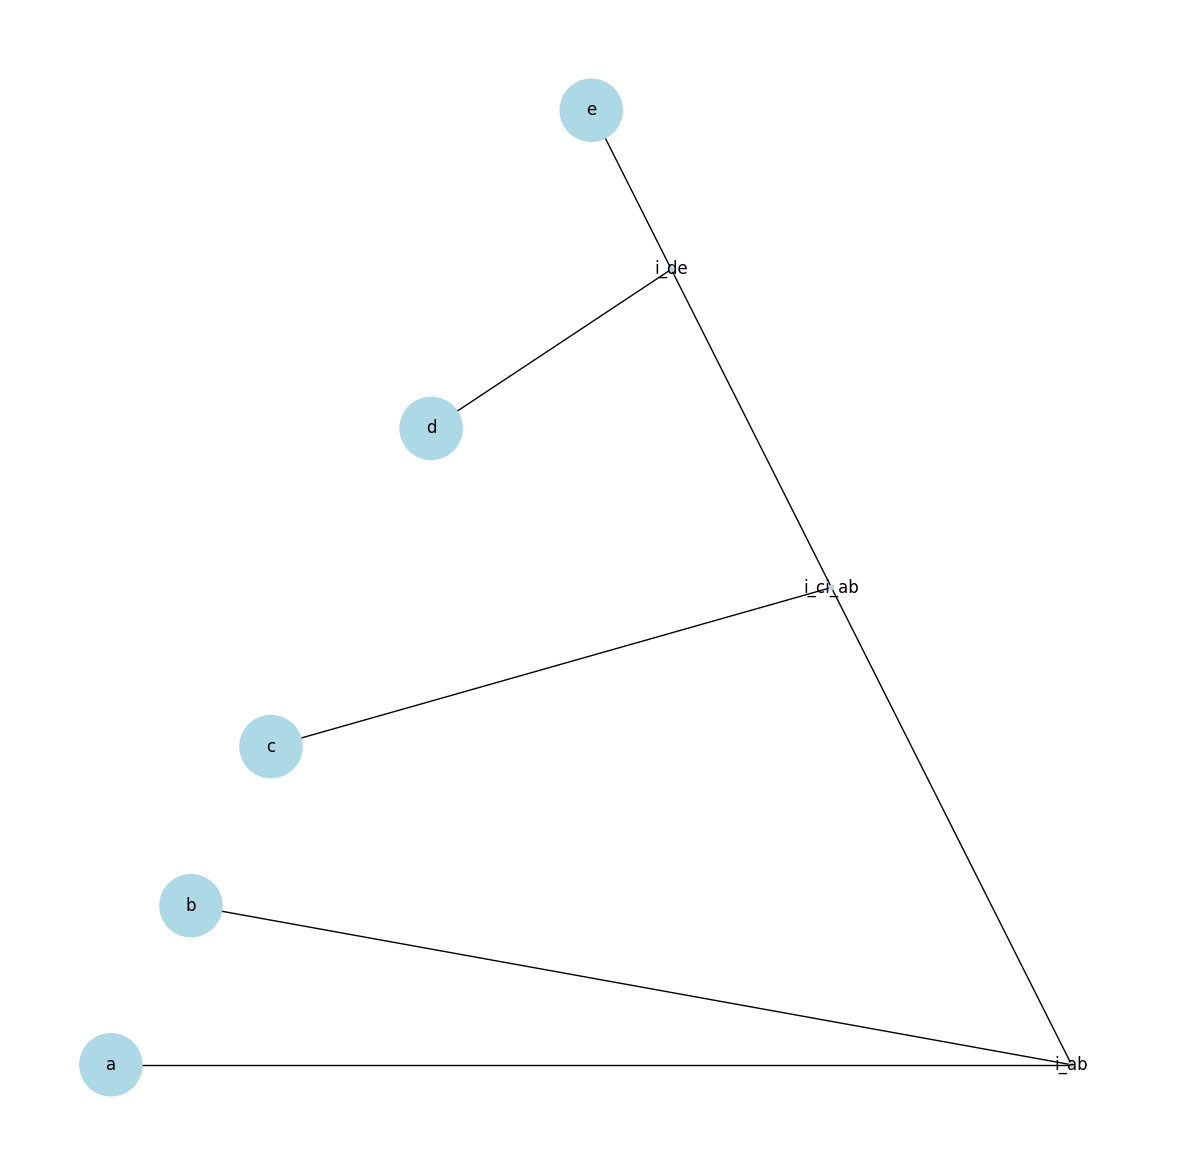

In [270]:
draw_graph_nice(G)

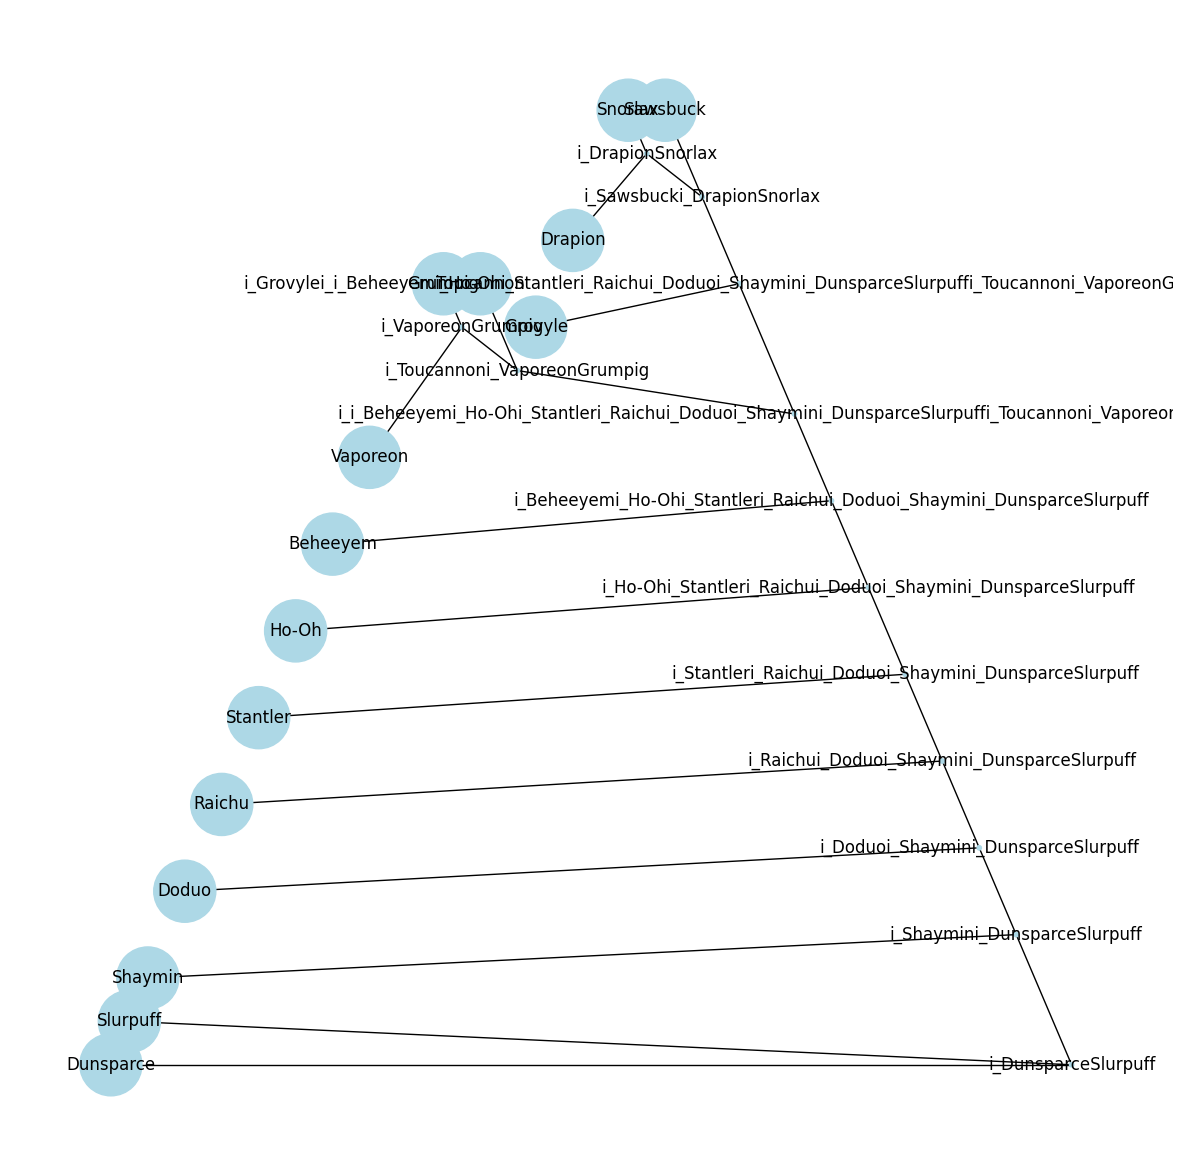

In [283]:
# Get sequences
sequences, seq_names = utils.get_sequences_for_ancestry()

dists = get_dist_matrix(sequences)
G_pokemon = construct_alignment(dists, seq_names)

draw_graph_nice(G_pokemon)

<div class="alert alert-success">
    
**Problem 4 (b).** Given $n$ sequences each of roughly the same length $m$, what would the time complexity be for constructing such a phylogenetic tree? Can you think of any algorithms or heuristics that might make the process faster? 
    
</div>

First, we build the distance matrix which is $\Theta(n^2m^2)$ because we are comparing each sequence with every other sequence (which is $\Theta(n^2)$ and we are computing their alignment scores which is $\Theta(m^2)$

The phylogenetic tree construction (not including building the distance matrix) is $\Theta(n^3)$ with our implementation. This is because we are finding the minimum value in the distance matrix (which is an $\Theta(n^2)$ operation because this is an nxn matrix) and we are doing this n times.

So, the total time complexity would be $\Theta(n^2m^2 + n^3)$

To make the process faster, we can build a AVL binary search tree from the distance matrix to make the process of finding the minimum value $O(nlogn)$.

<div class="alert alert-success">

**Problem 4 (c).** Assume a direct correlation between the distance between any two nodes and the number of years (in millions) between their evolution. Assuming `Grumpig` was the first Pokémon to evolve, when did life first come to be in the fictional scenario?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

In [285]:
grpg_i = seq_names.index("Grumpig")
grpg_dists = dists[grpg_i]

max_dist = float("-inf")
max_pokemon = None
for i in range(len(grpg_dists)):
    if grpg_dists[i] > max_dist and seq_names[i] != "Grumpig":
        max_dist = grpg_dists[i]
        max_pokemon = seq_names[i]
        
print(max_dist, max_pokemon)
    
# OTHER APPROACHES - IGNORE
# paths = nx.shortest_path(G_pokemon, source="Grumpig", weight="weight")
# max_dist = 0
# for p in paths:
#     dist = 0
#     pokemon = None
#     for i in range(len(p)-1):
#         dist += G_pokemon.edges[p[i],p[i+1]]["weight"]
#     if dist > max_dist:
#         max_dist = dist
#         pokemon = p

# print(max_dist, pokemon)
        

# most_recent_pokemon = None
# max_dist_grpg = float('-inf')

# for edge in G_pokemon.edges(data=True):
#     if edge[0] == 'Grumpig' and edge[2].get("weight") > max_weight:
#         most_recent_pokemon = edge[1]
#         max_dist_grpg = edge[2].get("weight")
#     elif edge[1] == 'Grumpig' and edge[2].get("weight") > max_weight:
#         most_recent_pokemon = edge[0]
#         max_dist_grpg = edge[2].get("weight")

45.45454545454544 Doduo


In [286]:
how_long_ago = "???" # Replace with your answer
how_long_ago = max_dist
print(f"Life evolved {how_long_ago} million years ago in the Pokémon world")

Life evolved 45.45454545454544 million years ago in the Pokémon world


One way to test the robustness of such a tree reconstruction algorithm is to consider collection of nodes independently and see if the recontructed sub-trees match the bigger tree.

<div class="alert alert-success">
    
**Problem 4 (d).** Find an  edge between intermediate nodes with the largest weight in the phylogenetic tree and remove that edge- this will produce two disjoint cluster of nodes. Re-run your tree reconstruction algorithm on these two sets of Pokémons. Do your reconstructed tree match the larger phylogenetic tree?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

('i_Shaymini_DunsparceSlurpuff', 'i_Doduoi_Shaymini_DunsparceSlurpuff', {'weight': 4.616219680149136})


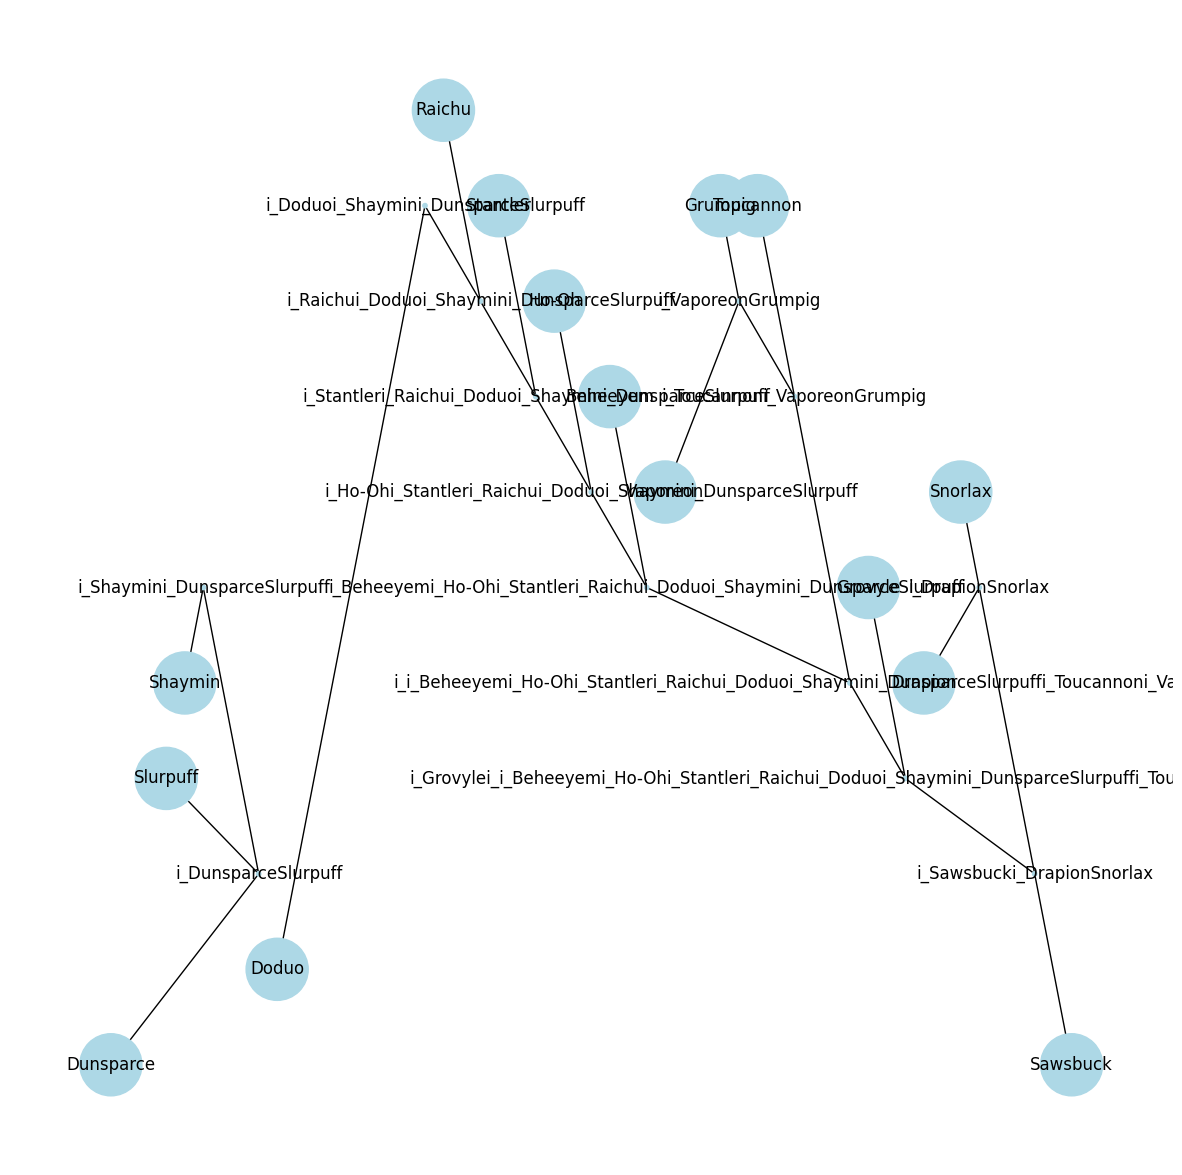

In [287]:
# Your code here
max_edge = None
max_weight = float("-inf")

for edge in G_pokemon.edges(data=True):
    if "i_" not in edge[0] or "i_" not in edge[1]:
        continue
    if edge[2].get("weight") > max_weight:
        max_edge = edge
        max_weight = edge[2].get("weight")

G_new = G_pokemon
G_new.remove_edge(max_edge[0], max_edge[1])
print(max_edge)

draw_graph_nice(G_new)

Yes, the reconstructed tree represents subtrees from the larger phylogenetic tree, so it matches the larger tree.

<div class="alert alert-success">

**Problem 4 (d).** Can you inspect the matrix of distances between the Pokémons and predict whether the reconstructed trees would always be unique? Why/why not?
</div>

If in the distance matrix, all of the distances are unique, that means that the tree will always be unique. However, if there are two different pairs of Pokemon that have the same distance from each other, that means that the tree will not always be unique because the constructed tree depends on which pair of Pokemon is chosen for merge first.

In [257]:
import pandas as pd

print(pd.DataFrame(dists))

           0          1          2          3          4          5   \
0    0.000000  19.230769  13.157895  17.857143  23.809524  16.129032   
1   19.230769   0.000000  20.833333  18.518519  20.000000  15.625000   
2   13.157895  20.833333   0.000000  10.204082  21.739130  16.129032   
3   17.857143  18.518519  10.204082   0.000000  12.195122  18.518519   
4   23.809524  20.000000  21.739130  12.195122   0.000000  11.363636   
5   16.129032  15.625000  16.129032  18.518519  11.363636   0.000000   
6    8.474576  15.151515  11.111111  12.820513  10.638298  11.904762   
7    9.803922  20.833333  20.000000   7.812500  23.809524  11.111111   
8   11.363636  17.857143  20.000000  22.727273  12.820513  45.454545   
9   29.411765  38.461538   8.928571  20.000000  35.714286  15.151515   
10  13.888889  15.151515  19.230769  14.705882  11.111111  23.809524   
11  26.315789  20.000000  20.833333  11.627907  19.230769  16.666667   
12  29.411765  50.000000  17.857143  17.857143  13.888889  14.70

## Part 5: Tracing Evolution

<div class="alert alert-warning">
    This problem is a "Challenge Problem". This means it is a problem of unknown difficulty that might be quite challenging (unlike the earlier problems, we don't have a reference solution for this one, or a clear idea how hard it might be). We do hope all students will at least attempt this and that more ambitious students will work hard to solve it and learn interesting things by the attempt (whether or not it is successful), but not get frustrated if you can't get to the desired answer.  As a "Challenge Problem" it means that you shouldn't be worried if you are not able to solve this, though, and you can get full expected credit on this assignment without answering it.
</div>


Now that we can construct Phylogenetic trees using sequence alignment, we can attempt to construct these trees for different organisms and trace their evolution through time. You're given reads processed from a FASTA file for Hemoglobin Beta Proteins, which can be used to then trace evolution based on how similar their sequences are across organisms from different kingdoms. Each record has the following relevant information in Tuple format:

`((uniprot identifier, full name, shortened name, group), (sequence))`

As you may notice, running our nearest-neighbor reconstruction algorithm on this data will give a Phylogenetic tree that does not fully correspond to what we know about the evolution of these species.

<div class="alert alert-success">
    
**Problem 8 (Challenge).** Construct a Phylogenetic Tree using the given sequences. Implement and use any tree-reconstruction method of your choice, and see if it works better than the nearest-neighbor method with a linear-gap penalty.
    
For visualization, use the short name to display in the evolution tree.
    
</div>
    
This is an open-ended question, and is inspired by https://www.mimuw.edu.pl/~lukaskoz/teaching/sad2/lab6/readme.html. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have.

In [244]:
sequences = utils.get_sequences_for_tree()
print(sequences[0])

(('P01941.1', 'Tupaia glis', 'Tgli', 'Mammalia'), 'VLSPGDKSNIKAAWGKIGGQAPQYGAEALERMFLSFPTTKTYFPHFDMSHGSAQIQAHGKKVADALSTAVGHLDDLPTALSALSDLHAHKLRVDPANFKLLSHCILVTLACHHPGDFTPEIHASLDKFLANVSTVLTSKYR')


In [245]:
# Your code here

_Write a description of your algorithm, and things you learned from working on this here._

_Type your answer here_

<div class="alert alert-success">
    
Is this (using Hemoglobin proteins) the best way to trace and visualize evolution? Why do you think it is useful, and what could the possible downsides of this be?
    
</div>

_Type your answer here_

   <div class="alert alert-block alert-danger">
    <center>
      
**End of Project 2!**
        
Remember to follow the submission directions above to submit your assignment.
    
 </center>
 </div>